## 基于经典网络架构训练图像分类模型

### 数据预处理部分：
#### • 数据增强：torchvision中transforms模块自带功能，比较好用
#### • 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
#### • DataLoader模块直接读取batch模块

### 网络模块设置
#### • 加载预处理模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
#### • 需要注意的是别人训练好的任务跟咱们的可不是完全一样的，需要把最后的head层改一改。一般也就是最后的全连接层，改成咱们自己的任务
#### • 训练时可以全部重头训练，也可以只训练咱们任务的层，因为前几层都是做任务提取的，本质任务目标是一致的

### 网络模型保存与设置
#### • 模型保存的时间可以带有选择性，例如在验证集中如果当前效果好则保存
#### • 读取模型进行实际测试

In [1]:
import os, json, copy, joblib, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, datasets

from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


### 读取数据与预处理操作

### 制作好数据来源
#### • data_transforms中指定了所有图像预处理操作
#### • ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字

In [3]:
data_dir = 'D:\\机器学习项目实战数据集\\花卉图像识别\\flower_data'

with open('D:\\机器学习项目实战数据集\\花卉图像识别\\cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(f"任务：花卉图像多分类（共 {len(cat_to_name)} 类）")
print("各类别花卉对应名字如下：")
cat_to_name

任务：花卉图像多分类（共 102 类）
各类别花卉对应名字如下：


{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

batch_size = 128

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    for x in ['train', 'valid']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print("类别数量:", len(class_names))

{'train': 6552, 'valid': 818}
类别数量: 102


### SimpleCNN模型定义: 从零开始训练调参， 三层卷积层，均包含卷积，激活，池化等操作，对最终结果在进行全局操作

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


simple_model = SimpleCNN(102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(simple_model.parameters(), lr=1e-3)
scaler = GradScaler()

### 训练与验证SimpleCNN模型

In [6]:
epochs = 25
simple_train_acc, simple_val_acc = [], []

for epoch in range(epochs):
    simple_model.train()
    correct = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = simple_model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / dataset_sizes['train']
    simple_train_acc.append(train_acc)

    simple_model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = simple_model(inputs)
            correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = correct / dataset_sizes['valid']
    simple_val_acc.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train {train_acc:.4f} | Val {val_acc:.4f}")
    
print(f"最佳验证准确率: {max(simple_val_acc):.4f} (第{simple_val_acc.index(max(simple_val_acc))+1}轮)")

Epoch 1/25 | Train 0.0475 | Val 0.0721
Epoch 2/25 | Train 0.0752 | Val 0.1027
Epoch 3/25 | Train 0.0983 | Val 0.1553
Epoch 4/25 | Train 0.1120 | Val 0.1406
Epoch 5/25 | Train 0.1328 | Val 0.1822
Epoch 6/25 | Train 0.1456 | Val 0.2029
Epoch 7/25 | Train 0.1632 | Val 0.2078
Epoch 8/25 | Train 0.1749 | Val 0.2188
Epoch 9/25 | Train 0.1778 | Val 0.2347
Epoch 10/25 | Train 0.1981 | Val 0.2335
Epoch 11/25 | Train 0.2103 | Val 0.2616
Epoch 12/25 | Train 0.2170 | Val 0.2628
Epoch 13/25 | Train 0.2245 | Val 0.2836
Epoch 14/25 | Train 0.2382 | Val 0.2934
Epoch 15/25 | Train 0.2486 | Val 0.3240
Epoch 16/25 | Train 0.2500 | Val 0.3203
Epoch 17/25 | Train 0.2651 | Val 0.3240
Epoch 18/25 | Train 0.2700 | Val 0.3276
Epoch 19/25 | Train 0.2735 | Val 0.3545
Epoch 20/25 | Train 0.2813 | Val 0.3350
Epoch 21/25 | Train 0.2952 | Val 0.3545
Epoch 22/25 | Train 0.3017 | Val 0.3753
Epoch 23/25 | Train 0.3028 | Val 0.3484
Epoch 24/25 | Train 0.2982 | Val 0.3692
Epoch 25/25 | Train 0.3048 | Val 0.3875
最佳验证准确率: 

### cnn特征提取

In [7]:
feature_extractor = copy.deepcopy(simple_model)
feature_extractor.classifier = nn.Identity()
feature_extractor.eval()


def extract_features(loader):
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            feat = feature_extractor(x)
            feat = feat.view(feat.size(0), -1)  
            feats.append(feat.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(feats), np.concatenate(labels)


X_train, y_train = extract_features(dataloaders['train'])
X_val, y_val = extract_features(dataloaders['valid'])

print("训练特征形状:", X_train.shape)
print("验证特征形状:", X_val.shape)

训练特征形状: (6552, 128)
验证特征形状: (818, 128)


### 特征可视化

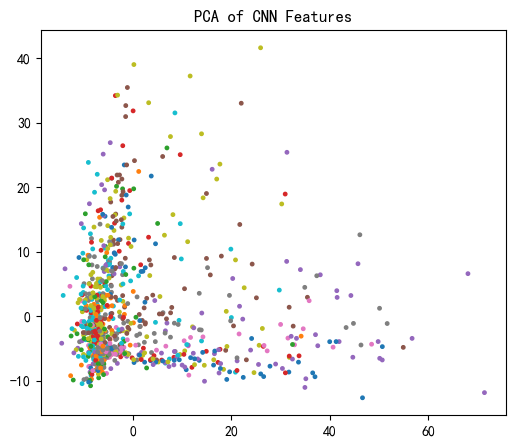

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train[:1000])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=y_train[:1000], cmap='tab10', s=6)
plt.title("PCA of CNN Features")
plt.show()

### svm超参数与gridsearch网格搜索

In [9]:
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

param_grid = {
    'svm__C': [1, 10],
    'svm__gamma': ['scale', 0.01]
}

grid = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

print("开始 SVM 网格搜索...")
grid.fit(X_train, y_train)

svm_best = grid.best_estimator_
svm_preds = svm_best.predict(X_val)

print(classification_report(y_val, svm_preds, target_names=class_names))

开始 SVM 网格搜索...
              precision    recall  f1-score   support

           1       0.75      0.38      0.50         8
          10       0.43      0.75      0.55         4
         100       1.00      1.00      1.00         6
         101       0.33      0.40      0.36         5
         102       0.38      0.50      0.43         6
          11       0.60      0.30      0.40        10
          12       0.44      0.80      0.57         5
          13       0.21      0.60      0.32         5
          14       0.20      1.00      0.33         1
          15       0.57      0.57      0.57         7
          16       0.25      0.50      0.33         2
          17       0.58      0.69      0.63        16
          18       0.18      0.18      0.18        11
          19       0.25      0.25      0.25         4
           2       0.71      0.83      0.77         6
          20       0.00      0.00      0.00         7
          21       0.50      0.50      0.50         4
          22

### 模型对比：自己定义的SimpleCNN与经过SVM的CNN进行对比

In [10]:
simple_model.eval()
cnn_preds = []

with torch.no_grad():
    for inputs, _ in dataloaders['valid']:
        inputs = inputs.to(device)
        outputs = simple_model(inputs)
        cnn_preds.extend(outputs.argmax(1).cpu().numpy())

cnn_acc = accuracy_score(y_val, cnn_preds)
svm_acc = accuracy_score(y_val, svm_preds)

print(f"SimpleCNN 验证准确率: {cnn_acc:.4f}")
print(f"CNN 特征 + SVM 验证准确率: {svm_acc:.4f}")

SimpleCNN 验证准确率: 0.0098
CNN 特征 + SVM 验证准确率: 0.4829


### 用两个训练好的来对相同的图片进行预测展示

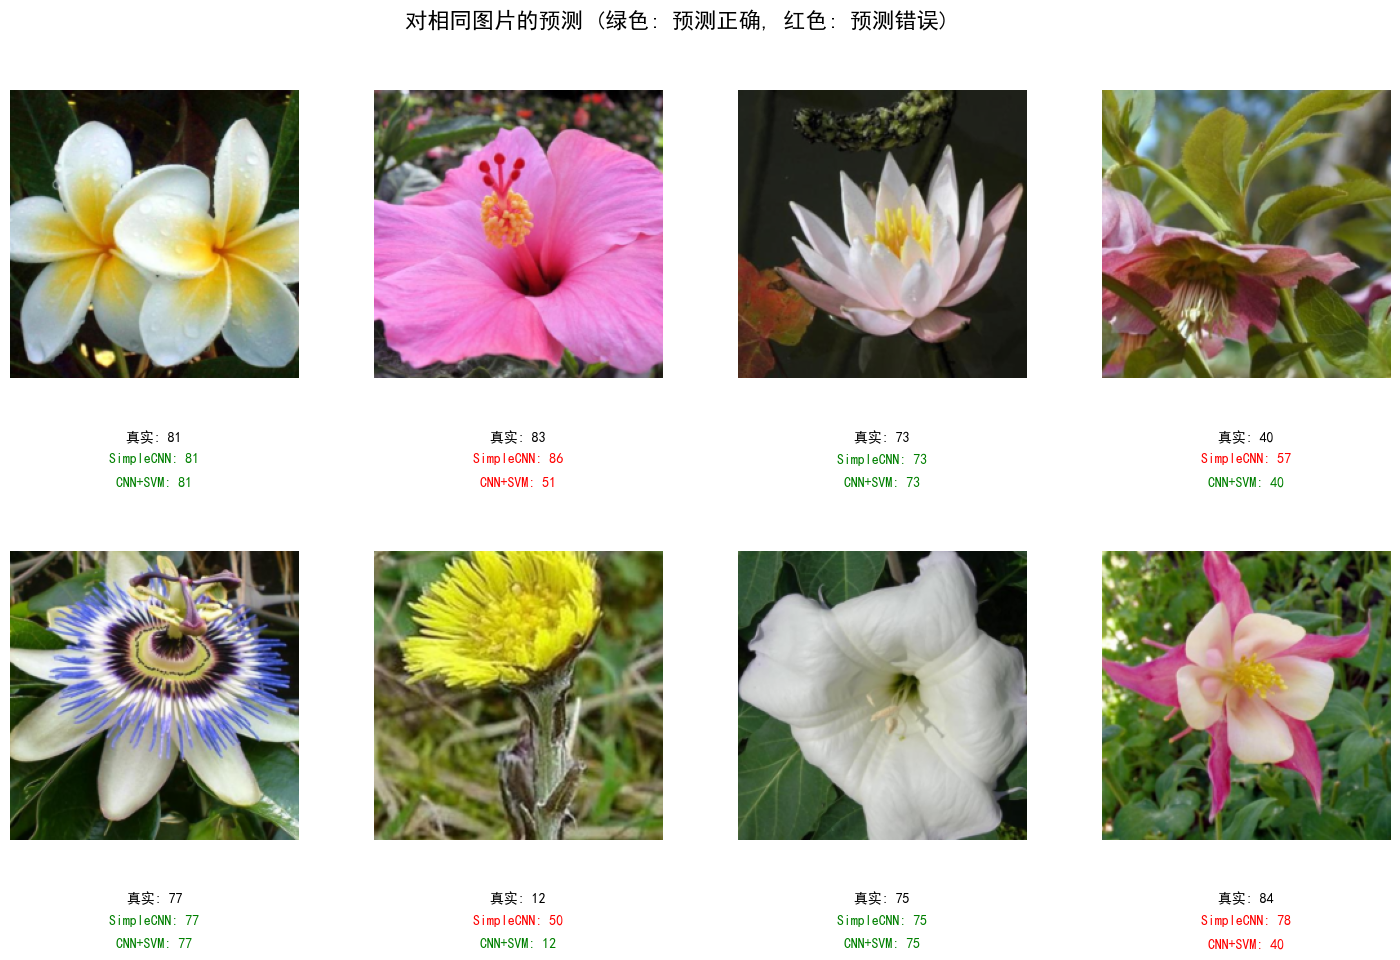

In [27]:
def visualize_cnn_vs_svm_predictions(
    simple_cnn,
    feature_cnn,
    svm_model,
    dataloader,
    class_names,
    device,
    num_images=8
):
    simple_cnn.eval()
    feature_cnn.eval()

    images_so_far = 0
    fig = plt.figure(figsize=(18, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            cnn_preds = simple_cnn(inputs).argmax(1)

            feat = feature_cnn(inputs)
            feat = torch.flatten(feat, 1)
            svm_preds = svm_model.predict(feat.cpu().numpy())

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)

                # -------- 图像 --------
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + \
                      np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                ax.imshow(img)
                ax.axis("off")

                true = labels[j].item()
                cnn_p = cnn_preds[j].item()
                svm_p = svm_preds[j]

                y0 = -0.18   

                ax.text(
                    0.5, y0,
                    f"真实: {class_names[true]}",
                    transform=ax.transAxes,
                    ha="center", va="top",
                    fontsize=10, color="black"
                )

                ax.text(
                    0.5, y0 - 0.08,
                    f"SimpleCNN: {class_names[cnn_p]}",
                    transform=ax.transAxes,
                    ha="center", va="top",
                    fontsize=10,
                    color="green" if cnn_p == true else "red"
                )

                ax.text(
                    0.5, y0 - 0.16,
                    f"CNN+SVM: {class_names[svm_p]}",
                    transform=ax.transAxes,
                    ha="center", va="top",
                    fontsize=10,
                    color="green" if svm_p == true else "red"
                )

                if images_so_far == num_images:
                    fig.suptitle(
                        "对相同图片的预测 (绿色: 预测正确, 红色: 预测错误)",
                        fontsize=16
                    )
                    fig.subplots_adjust(top=0.9, bottom=0.15, hspace=0.6)
                    plt.show()
                    return
    
visualize_cnn_vs_svm_predictions(
    simple_cnn=simple_model,
    feature_cnn=feature_extractor,
    svm_model=svm_best,
    dataloader=dataloaders["valid"],
    class_names=class_names,
    device=device,
    num_images=8
)